<table style="width: 100%; border-style: none">
<tr style="border-style: none; background-color: #82a8cf">
<td style="border-style: none; width: 1%; text-align: left; font-size: 16px; color: #ffffff">Institut f&uuml;r Theoretische Physik<br /> <font color="#e6e6e6">Universit&auml;t zu K&ouml;ln </font></td>
<td style="border-style: none; width: 1%; font-size: 16px">&nbsp;</td>
<td style="border-style: none; width: 1%; text-align: right; font-size: 16px; color: #ffffff">Prof. Dr. Simon Trebst<br /> <font color="#e6e6e6"> Theo Haas </font> </td>
</tr>
</table>
<hr>
<h1 style="font-weight:bold; text-align: center; margin: 10px; padding:0px;">Computerphysik</h1>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">Vorlesung - Programmiertechniken 10</h1>
<hr>
<h3 style="font-weight:bold; text-align: center; margin: 0px; padding:0px; margin-bottom: 20px;">Sommersemester 2025</h3>

**Website:** <a href="https://www.thp.uni-koeln.de/trebst/Lectures/2025-CompPhys.shtml" style="color:#82a8cf; text-decoration: underline;text-decoration-style: dotted;">https://www.thp.uni-koeln.de/trebst/Lectures/2025-CompPhys.shtml</a>

**Themen dieses Notebooks:** Ziffernerkennung mit neuronalen Netzen, stochastic gradient descent und mini batches.
<hr>

# Teil II &mdash; Neuronales Netz mit Optimierung via "stochastic gradient descent" und "mini batches"

### Der <a href="https://en.wikipedia.org/wiki/MNIST_database">MNIST Datensatz</a> handschriftlicher Ziffern

Wir arbeiten nun mit dem sogenannten <a href="https://en.wikipedia.org/wiki/MNIST_database">MNIST Datensatz</a> handschriftlicher Ziffern, der standardmäßig dazu genutzt wird, um die Qualität verschiedener Designs von neuronalen Netzen zu überprüfen. 

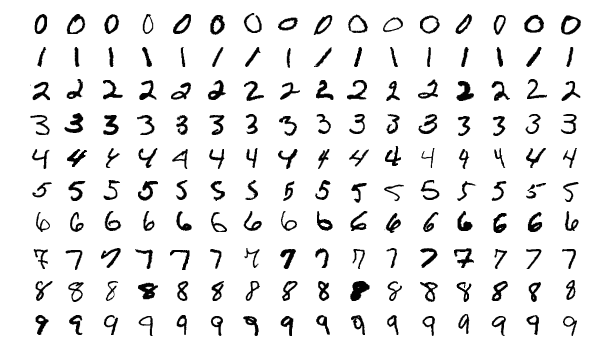

Dazu laden wir ihn zunächst hinunter und untersuchen dann den Inhalt.

In [ ]:
using CairoMakie
using LaTeXStrings
using DataFrames
using CSV
using Random

Die erste Spalte ist das Label, während der Rest eine digitalisierte, handschriftliche Ziffer der Größe $28 \times 28$ darstellt. Wir separieren nun Label von Zahl und betrachten dann ein paar Beispielziffern.

In [ ]:
# DOWNLOAD FILES FROM SERVER
if !isfile("mnist_train.csv")
    download("http://www.thp.uni-koeln.de/trebst/Lectures/CompPhys-2025/mnist_train.csv", "mnist_train.csv")
end
if !isfile("mnist_test.csv")
    download("http://www.thp.uni-koeln.de/trebst/Lectures/CompPhys-2025/mnist_test.csv", "mnist_test.csv")
end


# READ RAW DATA
test  = CSV.read("mnist_test.csv",  DataFrame, header=false)
train = CSV.read("mnist_train.csv", DataFrame, header=false)

# Ausgabe der RAW Daten Groesse
println("Größe der Datensätze")
println(size(test))
println(size(train))

Für jeden einzelnen Datensatz ist die erste Spalte das Label, während der Rest eine digitalisierte, handschriftliche Ziffer im Format von $28 \times 28 = 784$ Pixeln darstellt. Wir separieren nun, in einem ersten Schritt, das Label von der pixelierten Ziffer und betrachten dann ein paar Beispielziffern.

In [ ]:
# generiere Einzellisten TEST SET
test_inputs = Matrix(test[:, 2:end]) ./ 255
test_labels = zeros(Float64, size(test_inputs, 1), 10)
# konvertiere i --> 0, 0, 0, ... 0, 1, 0 wobei 1 an Stelle i steht.
for i in 1:size(test_inputs)[1]
    test_labels[i,test[i, 1] + 1] = 1.0
end

# generiere Einzellisten TRAINING SET
train_inputs = Matrix(train[:, 2:end]) ./ 255
train_labels = zeros(Float64, size(train_inputs, 1), 10)
# konvertiere i --> 0, 0, 0, ... 0, 1, 0 wobei 1 an Stelle i steht.
for i in 1:size(train_inputs)[1]
    train_labels[i,train[i, 1] + 1] = 1.0
end

### Visualisierung

In [ ]:
fig = Figure(size = (600, 600))

println("Beispiele Training-Set")
println(train_labels[1, :],"   Ziffer = ", findmax(train_labels[1, :])[2]-1)
ax, p = heatmap(fig[1, 1], reshape(train_inputs[1, :], 28, 28)[:, end:-1:1], colormap = :binary )
hidedecorations!(ax)

println(train_labels[2, :],"   Ziffer = ", findmax(train_labels[2, :])[2]-1)
ax, p = heatmap(fig[1, 2], reshape(train_inputs[2, :], 28, 28)[:, end:-1:1], colormap = :binary )
hidedecorations!(ax)

println("\nBeispiele Test-Set")
println(test_labels[5, :],"   Ziffer = ", findmax(test_labels[5, :])[2]-1)
ax, p = heatmap(fig[2, 1], reshape(test_inputs[5, :], 28, 28)[:, end:-1:1], colormap = :binary)
hidedecorations!(ax)

println(test_labels[6, :],"   Ziffer = ", findmax(test_labels[6, :])[2]-1)
ax, p = heatmap(fig[2, 2], reshape(test_inputs[6, :], 28, 28)[:, end:-1:1], colormap = :binary)
hidedecorations!(ax)

fig

## Mini batches

Anstatt nun alle Datensätze auf einmal zu verwenden (wie wir es in dem ersten, einfacheren Beispiel getan haben), verwenden wir nun einzelne Teilmengen, sogenannte **mini batches**, um das Netz zu optimieren. Dabei ist es wichtig, dass diese Teilmengen groß genug sind, um die Gesamtmenge gut genug zu repräsentieren. Ausserdem sollten wir darauf achten, vor jedem Durchlauf die Daten zu mischen, um zu verhindern, dass in den Daten Zyklen enstehen, in denen das Netzwerk hängen bleibt. 

Die Anzahl der Durchläufe, die mit den gesamten Daten passieren, wird in diesem Kontext als **Epoche** bezeichnet. Wie viele man davon braucht, um eine Netzwerk ausreichend gut zu trainineren, hängt sehr stark vom Problem ab und muss empirisch bestimmt werden. 

**Elementares sigmoides Neuron**

In [ ]:
sigmoid(z)       = 1.0 / (1.0 + exp(-z));
sigmoid_prime(z) = sigmoid(z) * (1.0 - sigmoid(z));

**Netzwerk-Architektur**

In [ ]:
#----------------------
# INITIALIZATION BLOCK
#----------------------

# SET UP THE NEURAL NETWORK

# how many neurons per layer are there
n_input  = 28 * 28   # fixed by input
n_hidden = 200       # can be set by user # 200
n_output = 10        # fixed by number of letters


# the matrices describing the connections between layers
W_input_hidden  = (rand(n_hidden, n_input)  .- 0.5) .* 2.0;
W_hidden_output = (rand(n_output, n_hidden) .- 0.5) .* 2.0;

# the bias on every layer
B_hidden = (rand(n_hidden, 1) .- 0.5) .* 2.0;
B_output = (rand(n_output, 1) .- 0.5) .* 2.0;

**Überwachtes Lernen** des neuronalen Netzes mit **Back Propagation**, **Stochastic Gradient Descent** und **Mini Batches**

In [ ]:
#----------------------
# LEARNING BLOCK
#----------------------


# PARAMETERS

# Number of epochs of learning (i.e. iterations)
epochs     = 10
# size of every batch and number of batches
batch_size = 500
batches    = 20 # Eigentlich müsste hier stehen #Trainingsdaten / batchsize. 
# Learning parameter, strength of learning effect
gamma      = 0.01

# An array with all indices of test data, for shuffeling and sorting into batches
order_list = collect(1:size(train_inputs,1))


# LEARNING

# iterate over all epochs
for epoch in 1:epochs
    
    # gib die aktuelle epoche aus
    println("Epoche ", epoch)
        
    # shuffle the list of indices so the first ones are random
    shuffle!(order_list)
        
    # iterate over all batches
    for b in 1:batches
        
        # initialize the errors of the layer quantities
        dW_input_hidden  = zeros(size(W_input_hidden))
        dW_hidden_output = zeros(size(W_hidden_output))
        dB_hidden        = zeros(size(B_hidden))
        dB_output        = zeros(size(B_output))
        
        # collect the indices for this batch
        batch = order_list[1+(b-1)*batch_size : (b)*batch_size]
        # iterate over all data within this batch
        for i in batch
            
            # load the input data from the list
            input_data  = train_inputs[i, :]
            # load the target data, i.e. the expected output from the list
            target_data = train_labels[i, :]
            
            # propagate the input through the net to get the output        
            hidden_layer_values  =  sigmoid.( W_input_hidden * input_data + B_hidden )
            output_layer_values  =  sigmoid.( W_hidden_output * hidden_layer_values + B_output )
            
            # start backpropagation and determine the error in the result as well as the resulting delta
            result_err   = target_data - output_layer_values
            result_delta = result_err .* sigmoid_prime.(output_layer_values)
            
            # go on backpropagating to the hidden layer and do the same
            hidden_err   = W_hidden_output' * result_delta
            hidden_delta = hidden_err .* sigmoid_prime.(hidden_layer_values)
            
            # increase the overall errors with the respective values
            dW_input_hidden  += (hidden_delta * input_data') .* gamma
            dW_hidden_output += (result_delta * hidden_layer_values') .* gamma
            dB_hidden        += hidden_delta .* gamma
            dB_output        += result_delta .* gamma
        end
        
        # after the batch has been gone through, increment the weights and bias
        W_input_hidden  += dW_input_hidden
        W_hidden_output += dW_hidden_output
        B_hidden        += dB_hidden
        B_output        += dB_output
        
    end
    
end

**Anwendung** des optimierten Netzes auf den Test-Datensatz

In [ ]:
#----------------------
# TESTING BLOCK (I)
#----------------------

# choose a random test index
check = rand(1:size(test_inputs,1))

# show the image
fig, ax, p = heatmap( reshape(test_inputs[check, :], 28, 28)[:, end:-1:1], colormap = :binary )
hidedecorations!(ax)
display(fig)

# print the expected result
println("Expected result:  $( findmax(test_labels[check, :])[2]-1 )   ($(test_labels[check, :]))")

# propagate through the net and investigate output
input_data  = test_inputs[check, :]
hidden_layer_values  =  sigmoid.( W_input_hidden * input_data + B_hidden )
output_layer_values  =  sigmoid.( W_hidden_output * hidden_layer_values + B_output )
output = round.(output_layer_values, digits=3)
println("Neural net gives: $(findmax(output[:,1])[2]-1)   ($(output[:,1]))")

Berechnung der **Treffer-/Fehlerquote**

In [ ]:
#----------------------
# TESTING BLOCK (II)
#----------------------

# test all configurations, 0 correct to begin with
correct = 0

# iterate over all indices
for check in 1:size(test_inputs, 1)

    # expected result
    expected = findmax(test_labels[check, :])[2]-1

    # propagate through the net and investigate output
    input_data  = test_inputs[check, :]
    hidden_layer_values  =  sigmoid.( W_input_hidden * input_data + B_hidden )
    output_layer_values  =  sigmoid.( W_hidden_output * hidden_layer_values + B_output )
    output = round.(output_layer_values, digits=3)
    output_value = findmax(output[:,1])[2]-1
    
    # add to the list depending on correct or not
    if output_value == expected
        correct += 1
    end
    
end

# print how many were correct
println("$(correct) correct out of $(size(test_inputs,1))  ($(round(correct/size(test_inputs,1)*100, digits=2))%)")